Requires `run_bidcell.py` first.

In [51]:
%load_ext autoreload
%autoreload 2

from bidcell import BIDCellModel
import pandas as pd
import numpy as np
import skimage.io as sio
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
model = BIDCellModel("xenium_config.yaml")

In [22]:
df_spatial = pd.read_csv(model.config.files.fp_transcripts)
df_spatial.rename(columns={'x_location': 'x', 'y_location': 'y', 'z_location': 'z', 'feature_name': 'gene'}, inplace=True)

In [13]:
im = sio.imread(f'{model.config.files.data_dir}/model_outputs/2025_01_16_22_15_56/test_output/epoch_1_step_4000_connected.tif')
print(im.max())
im.shape

300801


(7997, 11494)

In [93]:
import h5py
f = h5py.File(f'{model.config.files.data_dir}/nuclei_cell_type.h5', 'r')
ct_id_per_cell = pd.Series(f['data'][:].astype(int), f['ids'][:].astype(int)).sort_index()
cell_type_names = pd.read_csv(model.config.files.fp_ref).sort_values('ct_idx').cell_type.values
cell_type_per_cell = pd.Series(cell_type_names[ct_id_per_cell], ct_id_per_cell.index)

In [102]:
dapi = sio.imread(f'{model.config.files.data_dir}/dapi_resized.tif')
dapi = np.minimum(dapi, np.quantile(dapi, 0.995))
print(dapi.max())
dapi.shape

3335.0


(7997, 11494)

## Check the image

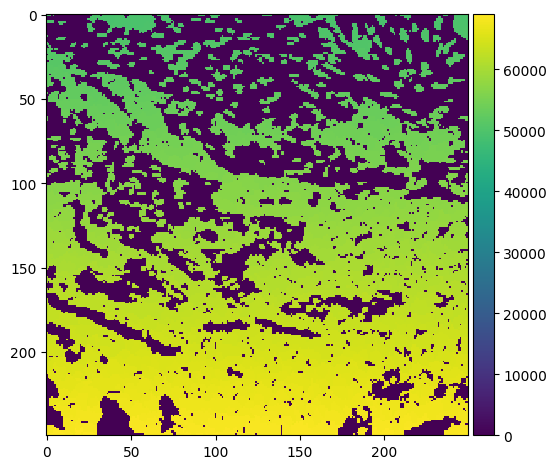

In [23]:
sio.imshow(im[2000:2500:2, 2000:2500:2])

## Check the molecules

In [149]:
df_spatial['cell_id'] = im[(
    df_spatial.y.values.astype(int), 
    df_spatial.x.values.astype(int)
)]

In [152]:
cell_df = df_spatial[['x', 'y', 'cell_id']].groupby('cell_id').mean().sort_index().loc[1:]
cell_df['cell_type'] = cell_type_per_cell.loc[cell_df.index]
cell_df.shape

(300713, 3)

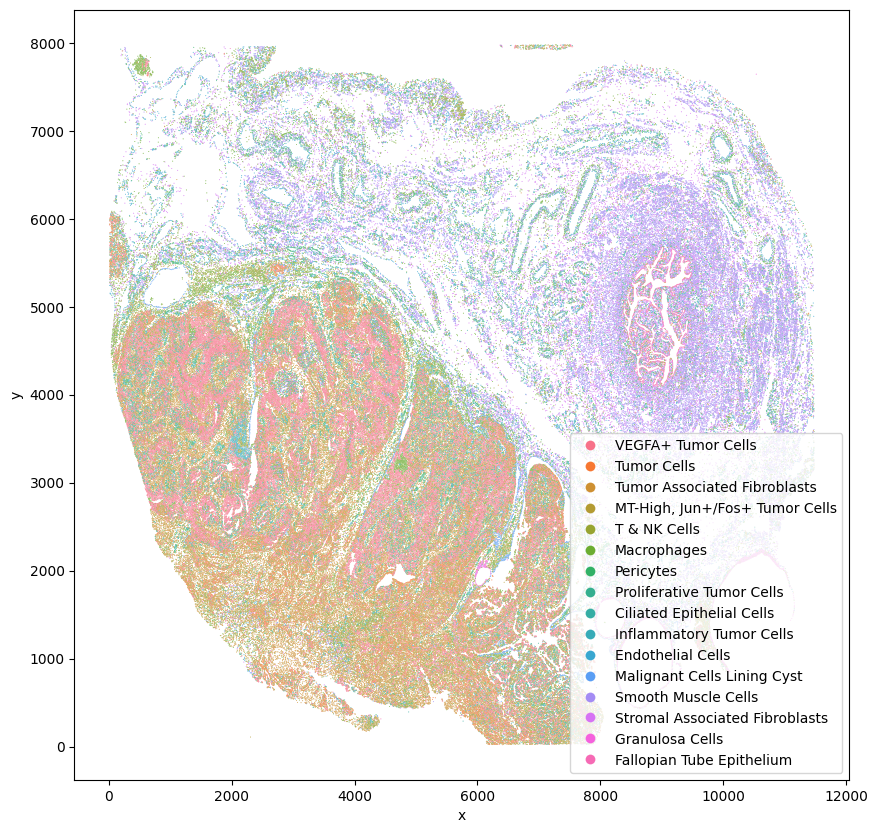

In [120]:
plt.figure(figsize=(10, 10))
sns.scatterplot(cell_df, x='x', y='y', hue='cell_type', s=0.5)
plt.legend(markerscale=10)

In [121]:
xs,xe = ys,ye = (2000, 2200)
df_subs = df_spatial.query(f'(x > {xs}) & (x < {xe}) & (y > {ys}) & (y < {ye})').copy()
df_subs.shape[0]

87177

In [122]:
df_subs['cell'] = [f'c{i}' for i in im[(df_subs.y.values.astype(int), df_subs.x.values.astype(int))]]
(df_subs.cell == 'c0').mean()

0.2826892414283584

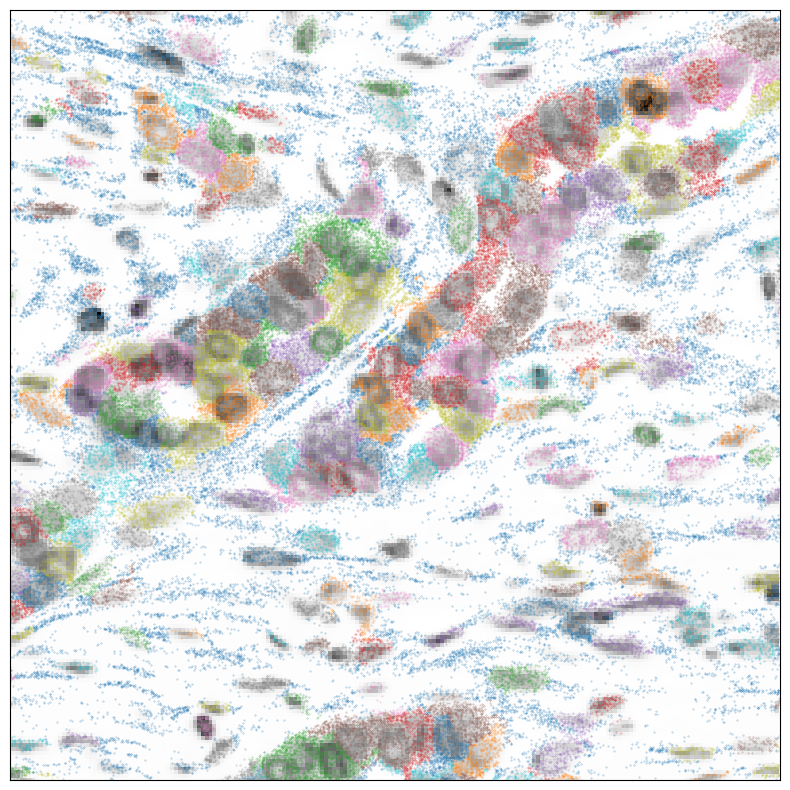

In [130]:
plt.figure(figsize=(10, 10))
plt.imshow(dapi[xs:xe, ys:ye], cmap='Grays')
for c in df_subs.cell.unique():
    plt.scatter(df_subs.x[df_subs.cell == c] - xs, df_subs.y[df_subs.cell == c] - ys, s=0.1, alpha=0.5)
plt.xlim(0, xe - xs); plt.ylim(0, ye - ys)
plt.xticks([]); plt.yticks([]);

## Save processed data

In [154]:
cell_df.to_csv(
    f'{model.config.files.data_dir}/cell_gene_matrices/2025_01_16_22_15_56/cell_meta.csv',
    index=True
)